In [1]:
import param
import panel as pn
import numpy as np
import pandas as pd
pn.extension()

/Users/kvandermeulen/kvmcode/thermoviz/venv_thermoviz/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


START with a simple reaction:
A->B:
a. dB/dt=-dA/dt=k[A]
b. [A]=[A]t0 * e^(-kt)



In [ ]:
gdrivepath=

In [2]:
class BaseClass(param.Parameterized):
    x = param.Parameter(default=3.14, doc="X position")
    y = param.Range(default=(2,3),bounds=(1,7),step=.5)

In [3]:
base=BaseClass()
pn.Row(base)

Row
    [0] Column(margin=5, name='BaseClass', width=300)
        [0] StaticText(value='<b>BaseClass</b>')
        [1] LiteralInput(name='X', value=3.14)
        [2] RangeSlider(end=7, name='Y', start=1, step=0.5, value=(2, 3), value_end=3, value_start=2)

In [5]:
df=pd.DataFrame.from_dict({'x':[3,4,5],'y':[1,3,13]})
source=ColumnDataSource(data=ColumnDataSource.from_df(df))

In [111]:
source.data

{'index': array([0, 1, 2]), 'x': array([3, 4, 5]), 'y': array([ 1,  3, 13])}

In [3]:
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource

class kinviewer(param.Parameterized):
    df=pd.DataFrame.from_dict({'x':[3,4,5],'y':[1,3,13]})
    source=ColumnDataSource(data=ColumnDataSource.from_df(df))    
    base=param.Range(default=(2,3),bounds=(1,7),step=.5)
    p=figure(height=200,width=400)
    #p.plot_width=300
    #p.plot_height=200
    #counter=0
    
    @param.depends('base')
    def plot_view(self):
        #self.counter+=1
        #self.source=ColumnDataSource(self.df)        
        #self.source.data={'x':[1,3,20],'y':[1,5,self.base[-1]*5]}
        self.source.data=ColumnDataSource.from_df(self.df)    
        self.source.data['y'][-1]=self.base[-1]*15
        self.p.circle(x='x',y='y',source=self.source)
        return pn.pane.Bokeh(self.p)
kv=kinviewer()
pn.Row(kv.param.base,kv.plot_view)

Row
    [0] RangeSlider(end=7, name='Base', start=1, step=0.5, value=(2, 3), value_end=3, value_start=2)
    [1] ParamMethod(method)

In [7]:
kv.base=(1,5)

In [145]:
print(kv.base.y)
print(kv.source.data)
print(kv.counter)

(2, 3)
{'x': [1, 3, 20], 'y': [1, 5, 27.5]}
1


In [59]:
x=np.arange(0,5,1)
y=np.arange(6,10,1)
z=np.concatenate((x,y))
z

array([0, 1, 2, 3, 4, 6, 7, 8, 9])

In [141]:
asec=np.arange(0,180,1)
adf=make_associationkinetics_df(asec,1e7,1e-7,1e-12,10e-9,0,general=False)
ddf=make_dissociationkinetics_df(asec,1e7,1e-1,.1e-12,0,.9e-12,general=False)

NameError: name 'analyte_conc' is not defined

In [139]:
adf=adf.rename(columns={'seconds':'sec_total'})
adf

,sec_total,theta,complex,ligand
0,0,0.000000,0.000000e+00,1.000000e-12
1,1,0.095163,9.516258e-14,9.048374e-13
2,2,0.181269,1.812692e-13,8.187308e-13
3,3,0.259182,2.591817e-13,7.408183e-13
4,4,0.329680,3.296799e-13,6.703201e-13
...,...,...,...,...
175,175,0.999999,9.999990e-13,1.025109e-18
176,176,0.999999,9.999990e-13,1.022719e-18
177,177,0.999999,9.999990e-13,1.020557e-18
178,178,0.999999,9.999990e-13,1.018601e-18


In [12]:
from bokeh.models.formatters import PrintfTickFormatter

In [14]:
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource,Range1d
#from bokeh.models.formatter import PrintfTickFormatter

def make_associationkinetics_df(seconds,ka,kd,ligand_0,analyte_0,complex_0,general=False):
    if general:
        print('general equation set (assuming analyte not in excess) not implemented yet')
        return None
    start_theta = complex_0/(analyte_0+complex_0)
    end_theta = analyte_0/(kd/ka + analyte_0)
    kobs = ka*analyte_0 + kd
    theta_t = start_theta+(end_theta-start_theta)*(1-np.exp(-kobs*seconds))
    complex_t = theta_t*(ligand_0 + complex_0)
    ligand_t = (ligand_0 + complex_0) - complex_t
    assocdf=pd.DataFrame(data={'seconds':seconds,'theta':theta_t,'complex':complex_t,'ligand':ligand_t})
    return assocdf
    
def make_dissociationkinetics_df(seconds,ka,kd,ligand_0,analyte_0,complex_0,general=False):
    #typically, analyte_0 should be = 0
    if general:
        print('general equation set (assuming analyte not in excess) not implemented yet')
        return None    
    start_theta = complex_0/(ligand_0+complex_0)
    end_theta = 0#analyte_0/(kd/ka + analyte_0)
    print(start_theta,end_theta)
    theta_t= (start_theta - end_theta)*np.exp(-kd*seconds)    
    complex_t = theta_t*(ligand_0 + complex_0)
    ligand_t = (ligand_0 + complex_0) - complex_t
    dissocdf=pd.DataFrame(data={'seconds':seconds,'theta':theta_t,'complex':complex_t,'ligand':ligand_t})
    return dissocdf

def make_sprdf(assoc_time,dissoc_time,ka,analyte_conc,kd):
    forward_seconds=np.arange(0,assoc_time,1)
    reverse_seconds=np.arange(0,dissoc_time,1)
    assocdf=make_associationkinetics_df(forward_seconds,ka,kd,1e-13,analyte_conc,0)
    assocdf=assocdf.rename(columns={'seconds':'seconds_assoc'})
    dissocdf=make_dissociationkinetics_df(forward_seconds,ka,kd,
                             assocdf.iloc[-1]['ligand'],analyte_conc,assocdf.iloc[-1]['complex'])
    dissocdf=dissocdf.rename(columns={'seconds':'seconds_dissoc'})  
    sprdf=pd.concat([assocdf,dissocdf],ignore_index=True)
    sprdf=sprdf.assign(seconds=np.arange(0,assoc_time+dissoc_time,1))
    return sprdf

class sprviewer(param.Parameterized):
    assoc_time=param.Number(180,bounds=(15,300),step=15)
    dissoc_time=param.Number(180,bounds=(15,300),step=15)
    ka=param.Parameter(10,label='ka (M-1s-1)',doc='bimolecular assoc. rate')#,format=PrintfTickFormatter(format='%.1e'))
    analyte_conc=param.Parameter(100,label='conc in nM',doc='analyte conc (nM)')
    kd=param.Parameter(0.1,label='kd (s-1)',doc='dissoc. rate')
    @param.depends('ka','analyte_conc','kd')
    def ka_obs(self):
        return pn.Pane(f'ka_obs={self.ka*self.analyte_conc*1e-9+self.kd:.1g}')
    @param.depends('ka','analyte_conc','kd')
    def Kd_eq(self):
        return pn.Pane(f'Kd (eq)={self.kd/self.ka:.1g}')
    
    df=pd.DataFrame(data={'seconds':[1,1],'theta':[1,1]})#make_sprdf(self.assoc_time,dissoc_time,ka,analyte_conc,kd)
    source=ColumnDataSource(data=ColumnDataSource.from_df(df))

    p=figure(height=300,width=600)
    p.y_range=Range1d(0,1)
    
    @param.depends('ka','kd','analyte_conc')
    def plot_view(self):
        self.df=make_sprdf(self.assoc_time,self.dissoc_time,self.ka,self.analyte_conc*1e-9,self.kd)
        self.source.data=ColumnDataSource.from_df(self.df)    
        self.p.line(x='seconds',y='theta',source=self.source)
        return pn.pane.Bokeh(self.p)
    
sprv=sprviewer()
pn.Row(pn.Column(sprv.param.ka,sprv.param.kd,sprv.param.analyte_conc,pn.Row(sprv.ka_obs,sprv.Kd_eq)),sprv.plot_view)


9.999899832714493e-06 0


0.9090909090909092 0 
0.09090909090909093 0 
0.5 0 
0.9090909090909092 0 
0.9999000099990001 0 
0.9900989959672186 0

Row
    [0] Column
        [0] LiteralInput(name='ka (M-1s-1)', value=10)
        [1] LiteralInput(name='kd (s-1)', value=0.1)
        [2] LiteralInput(name='conc in nM', value=100)
        [3] Row
            [0] ParamMethod(method)
            [1] ParamMethod(method)
    [1] ParamMethod(method)

In [4]:
1/53000

1.8867924528301888e-05

In [2]:
#first set up timescale
seconds=np.arange(0,10*60,1)

In [50]:
sprv.ka_obs

<bound method sprviewer.ka_obs of sprviewer(analyte_conc=100, assoc_time=180, base=(2, 3), dissoc_time=180, ka=15, kd=0.1, name='sprviewer00719')>

In [3]:
Ainit=10e-6
k=1e-2

(0.0, 1e-05)

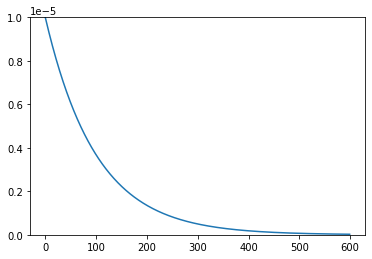

In [4]:
A=Ainit*np.exp(-k*seconds)
plt.plot(seconds,A)
plt.ylim(0,Ainit)

In [17]:
seconds

array([0])

In [25]:
float_slider.param.watch(cool, 'value')

Watcher(inst=FloatSlider(end=3.141, name='Float Slider', step=0.01, value=1.6), cls=<class 'panel.widgets.slider.FloatSlider'>, fn=<function cool at 0x000001F4B7A85700>, mode='args', onlychanged=True, parameter_names=('value',), what='value', queued=False)

In [26]:
def cool(thin):
    p1 = figure(width=300, height=300)
    A=Ainit*np.exp(-float_slider.value*seconds)
    p1.line(seconds,A )
    pnl=pn.panel(p1)
#    pnl.link(float_slider,)
#tabs = pn.Tabs(p1)
    return pnl

In [235]:
rawvec=np.array((.2,.3,-.1))
frobnorm=linalg.norm(rawvec)
rawvec/frobnorm

array([ 0.53452248,  0.80178373, -0.26726124])

# Matrix Stuffs

In [8]:
import scipy
from scipy import linalg

In [175]:
a=np.array(((-.3,0,0),(.3,-.1,0),(0,.1,0)))
a

array([[-0.3,  0. ,  0. ],
       [ 0.3, -0.1,  0. ],
       [ 0. ,  0.1,  0. ]])

In [234]:
eigstuff=linalg.eig(a)
eigstuff

(array([ 0. +0.j, -0.1+0.j, -0.3+0.j]),
 array([[ 0.        ,  0.        ,  0.53452248],
        [ 0.        ,  0.70710678, -0.80178373],
        [ 1.        , -0.70710678,  0.26726124]]))

In [246]:
eigval1=eigstuff[0][0].real
eigval2=eigstuff[0][1].real
eigval3=eigstuff[0][2].real
eigvec1=eigstuff[1][:,0]
eigvec2=eigstuff[1][:,1]
eigvec3=eigstuff[1][:,2]
eigvec2=np.array((0,1,-1))
eigvec3=np.array((-.2,.3,-.1))


In [248]:
diagmatrix=np.array([eigval3,eigval2,eigval1])*np.identity(3)
eigvecmatrix=np.array((eigvec3,eigvec2,eigvec1)).T
diagmatrix,eigvecmatrix

(array([[-0.3, -0. ,  0. ],
        [-0. , -0.1,  0. ],
        [-0. , -0. ,  0. ]]),
 array([[-0.2,  0. ,  0. ],
        [ 0.3,  1. ,  0. ],
        [-0.1, -1. ,  1. ]]))

In [249]:
expmatrix=np.exp(diagmatrix*4.5) #4.5 seconds into reaction...
expmatrix

array([[0.25924026, 1.        , 1.        ],
       [1.        , 0.63762815, 1.        ],
       [1.        , 1.        , 1.        ]])

In [250]:
eigvecmatrix@expmatrix@linalg.inv(eigvecmatrix)#@(np.array((1,0,0))).T

array([[-0.24075974, -0.4       , -0.2       ],
       [-2.68241816,  2.23762815,  1.3       ],
       [ 0.4231779 ,  0.16237185, -0.1       ]])

In [255]:
eigvecmatrix*expmatrix*linalg.inv(eigvecmatrix)@(np.array((1,0,0))).T

array([ 0.25924026,  0.45      , -0.1       ])

In [258]:
testa=np.array(((1,1),(1,1)))
testb=np.array(((1,2),(3,4))).T
testa@testb

array([[3, 7],
       [3, 7]])

In [223]:
eigstuff[1].T@expmatrix@linalg.inv(eigstuff[1].T)@(np.array((1,0,0)))

array([2.25924026, 0.26756064, 0.09256748])

In [196]:
diagmatrix@diagmatrix#(np.array((1,1,0)))

array([[0.  , 0.  , 0.  ],
       [0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.09]])

In [190]:
diagmatrix

array([[ 0. , -0. , -0. ],
       [ 0. , -0.1, -0. ],
       [ 0. , -0. , -0.3]])

In [212]:
eigvec2

array([ 0.        ,  0.70710678, -0.70710678])

In [211]:
a@eigvec2

array([ 0.        , -0.07071068,  0.07071068])

In [174]:
eigvec_array=np.array((eigvec1,eigvec2,eigvec3))
eigvec_array

array([[ 0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.70710678, -0.70710678],
       [ 0.53452248, -0.80178373,  0.26726124]])

In [259]:
5.6/285.6

0.019607843137254898

3.7735849056603776e-05

In [117]:
cmatrix=np.array((eigvec1,eigvec2,eigvec3))
cmatrixT=cmatrix.T

In [122]:
alpha=cmatrix@np.array((1,0,0))
alpha

array([0.        , 0.        , 0.53452248])

In [123]:
prod1=alpha[0]*eigvec1*np.exp(eigval1*1)
prod2=alpha[1]*eigvec2*np.exp(eigval2*1)
prod3=alpha[2]*eigvec3*np.exp(eigval3*1)
prods=prod1+prod2+prod3
prods
prod3

array([ 0.21166235, -0.31749352,  0.10583117])

In [ ]:
for second in seconds:
    prod1=alpha[0]*eigvec1*np.exp(eigval1*1)
    prod2=alpha[1]*eigvec2*np.exp(eigval2*1)
    prod3=alpha[2]*eigvec3*np.exp(eigval3*1)
    prods=prod1+prod2+prod3

In [63]:
seconds=np.arange(0,100)

### jump to here

In [173]:
eigvec_array@expmatrix@linalg.inv(eigvec_array)@(np.array((1,0,0)))

array([2.25924026, 0.26756064, 0.09256748])

In [23]:
eigstuff[0][0].real

0.0

In [24]:
eigstuff[1][0]

array([0.        , 0.        , 0.78446454])

In [25]:
linalg.inv(a)

LinAlgError: singular matrix

In [29]:
a

array([[-3,  0,  0],
       [ 3,  1,  0],
       [ 0,  1,  0]])

In [30]:
b=np.array((1,1,1))

In [28]:
a@np.array((1,1,1))

array([-3,  4,  1])

In [31]:
np.dot(a,b)

array([-3,  4,  1])

In [32]:
np.matmul(a,b)

array([-3,  4,  1])

In [34]:
a[0,:]

array([-3,  0,  0])

In [ ]:
eig1=